In [2]:
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeClassifier, export_text
from sklearn.model_selection import cross_validate, train_test_split
from sklearn.tree import DecisionTreeRegressor, export_graphviz
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
import graphviz

In [3]:
# Grab ShootingSplits data set
# data was preprocessed removed data from before 2019
df = pd.read_csv('ShootingSplits_HeatCheckTourwTrap.csv')
df.tail(2)

,Unnamed: 0,YEAR,TEAM NO,TEAM ID,TEAM,CONF,DUNKS FG%,DUNKS SHARE,DUNKS FG%D,DUNKS D SHARE,...,POWER,PATH,DRAW,WINS,POOL VALUE,POOL S-RANK,NCAA S-RANK,VAL Z-SCORE,POWER-PATH,Trapezoid
318,318,2019,741,241,Wofford,SC,92.6,6.3,85.7,4.0,...,71.8,70.7,0.46,1,14.5,23,28,0.227,1.1,0
319,319,2019,740,245,Yale,Ivy,94.3,9.3,82.6,4.1,...,58.4,75.7,0.66,0,3.6,48,53,0.613,-17.3,0


In [4]:
# splitting data into train/test set
df = df.dropna(axis=1)
df_train = df[df['YEAR'] != 2024]
df_test = df[df['YEAR'] == 2024]
print(df_train.shape)

# Adding trapezoid feature to dataset
c = df_train["Trapezoid"]
ctest = df_test["Trapezoid"]
df_train.head(2)

(256, 48)


,Unnamed: 0,YEAR,TEAM NO,TEAM ID,TEAM,CONF,DUNKS FG%,DUNKS SHARE,DUNKS FG%D,DUNKS D SHARE,...,SEED,ROUND,POWER,PATH,WINS,POOL VALUE,POOL S-RANK,NCAA S-RANK,POWER-PATH,Trapezoid
64,64,2023,1011,3,Alabama,SEC,88.7,13.0,85.2,5.3,...,1,16,85.2,63.8,2,74.7,4,1,21.4,0
65,65,2023,1010,8,Arizona,P12,90.9,9.4,90.9,5.7,...,2,64,80.9,65.3,0,57.5,7,7,15.6,0


In [5]:
# remove unwanted features
X_train = df_train.drop(['Unnamed: 0','YEAR','TEAM NO','TEAM ID','TEAM','CONF','WINS','ROUND'],axis=1)
X_test = df_test.drop(['Unnamed: 0','YEAR','TEAM NO','TEAM ID','TEAM','CONF','WINS','ROUND'],axis=1)
y_train = df_train.WINS
y_test = df_test.WINS
y_test.head(5)

0    0
1    4
2    2
3    0
4    1
Name: WINS, dtype: int64

In [6]:
# Standarizing data
X_train = (X_train - X_train.mean())/X_train.std()
X_test = (X_test - X_test.mean())/X_test.std()

In [7]:
# Creatin the decision tree and fitting to train data Clasifier route
dtree = DecisionTreeClassifier(max_depth=2)
dtree.fit(X_train,y_train)

DecisionTreeClassifier(max_depth=2)

In [8]:
# R2 of tree with depth 2
dtree.score(X_train,y_train)

0.5703125

In [9]:
# Tree nodes in text
dtree_string = export_text(dtree,feature_names = list(X_train.columns),decimals = 1, spacing = 6)
print(dtree_string)

|------ POOL VALUE <= 0.1
|      |------ PATH <= 0.6
|      |      |------ class: 0
|      |------ PATH >  0.6
|      |      |------ class: 0
|------ POOL VALUE >  0.1
|      |------ THREES D SHARE <= 0.3
|      |      |------ class: 1
|      |------ THREES D SHARE >  0.3
|      |      |------ class: 2



In [10]:
cv_results = cross_validate(dtree,X_train,y_train)
acc_valid = cv_results['test_score'].mean()
print('validation accuracy rate',acc_valid)

validation accuracy rate 0.503921568627451


C:\Users\hobbsji\AppData\Local\anaconda3\Lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


In [11]:
print("R2 of Decision Tree classifier: ", dtree.score(X_test,y_test))

R2 of Decision Tree classifier:  0.53125



best alpha = {'max_depth': 2}   valid R2 = 0.193


<Axes: xlabel='depth'>

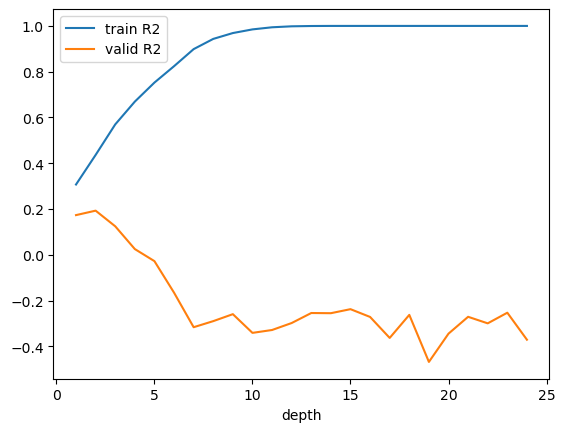

In [12]:
# Switch to decision tree gegressor 
grid = {'max_depth':np.arange(1,25)}

# work from depths 1 to 25 to see who has the best results
dtree = DecisionTreeRegressor()
dtreeCV = GridSearchCV(dtree,param_grid=grid,return_train_score=True)
dtreeCV.fit(X_train,y_train)

print()
print('best alpha =',dtreeCV.best_params_, '  valid R2 =',dtreeCV.best_score_.round(3))
#graph data
results = pd.DataFrame()
results['depth']    = grid['max_depth']
results['train R2'] = dtreeCV.cv_results_['mean_train_score']
results['valid R2'] = dtreeCV.cv_results_['mean_test_score']
ax1 = results.plot.line(x='depth',y='train R2')
results.plot.line(x='depth',y='valid R2',ax=ax1)

In [13]:
# random forest regressor to try and combat overfiiting with depth rising  
grid = {'n_estimators':[10,100,200],'max_depth':np.arange(1,30)} 
rf = RandomForestRegressor(n_jobs=-1) 
rfCV = GridSearchCV(rf,param_grid=grid,n_jobs=-1) 
rfCV.fit(X_train,y_train) 
print('best parameter',rfCV.best_params_) 
print('validation R2',rfCV.best_score_.round(2))

best parameter {'max_depth': 11, 'n_estimators': 100}
validation R2 0.29


In [14]:
# Grab optimized value
rf_opt = rfCV.best_estimator_
R2_train = rf_opt.score(X_train,y_train)
R2_test  = rf_opt.score(X_test,y_test)
print('Forest -> train R2 =',R2_train.round(3),'  test R2 =',R2_test.round(3))

Forest -> train R2 = 0.891   test R2 = 0.382


In [15]:
# Value doesn't beat ken data